In [1]:
import pandas as pd

# Utility Functions

In [2]:
# filter by country
def download_data(url_data, features)->pd.DataFrame:
    """download latest covid data from https://ourworldindata.org and return . Provide the url and the features you want."""
    df = pd.read_csv(url_data, usecols = features)
    # reorder columns
    df = df[features]
    # set date as index
    df.set_index('date', inplace=True)
    # Converting date to index
    df.index = pd.to_datetime(df.index)
    # check number of unique countries
    print('The dataset contains {} different countries'.format(df['location'].nunique())) 
    # check data type
    print('data types: ', df.dtypes)
    return df

def filter_country(dataframe:pd.DataFrame, LOCATION:str):
  """Filter dataframe by country. """
  return dataframe[dataframe.location == LOCATION]

def ts_filling(df_country:pd.DataFrame)->pd.DataFrame:
    """Fill missing data and smooth ts in dataframe of single country"""
    # backfill missing data by 2 months
    df = df_country.copy()
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=60, downcast=None)
    # forwardfill missing data by 2 months
    df.fillna(value=None, method='ffill', axis=0, inplace=True, limit=60, downcast=None)
    # smooth time series
    for col in df.columns[1:]:
        df[col] = df[col].rolling(21).median()
    # fill in new nas
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    return df

def add_new_deaths_pct_change(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate percent change between the median number of deaths 14 days earlier and the median number of deaths today"""
    df = df_country.copy()
    df['new_deaths_per_million_pct_change'] = df['new_deaths_per_million'].pct_change(periods=14, fill_method='pad', freq='D')
    #df['new_deaths_per_million_pct_change'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    df.dropna(axis=0, inplace=True)
    return df

def add_case_fatality_rate(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate case fatality rate CFR for single country df; CFR is the ratio between the 14-day median number of deaths and the 14-day median number of cases 14 days earlier """
    df = df_country.copy()
    df['case_fatality_rate'] = df['new_deaths_per_million'] / df['new_cases_per_million'].shift(14)
    # set inf values to zero i.e. the assumption is when there are no cases then there are no deaths
    df['case_fatality_rate'][df['new_cases_per_million']==0] = 0
    # set na values to zero i.e. the assumption is when there are no deaths and at the same time zero cases, then CFR is still zero
    df['case_fatality_rate'][df['new_deaths_per_million']==0] = 0
    # cfr above 100% makes no sense
    df['case_fatality_rate'][df['case_fatality_rate']>1] = 1
    # do a little smoothing i.e. average over 7 days
    df['case_fatality_rate'] = df['case_fatality_rate'].rolling(7).median()
    ## fill in new nas
    #df['case_fatality_rate'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    df.dropna(axis=0, inplace=True)
    return df

# filter by date
def filter_date(dataframe:pd.DataFrame, start_date:str, end_date:str)->pd.DataFrame:
  """Filter dataframe by date range including start_date and end_date. """
  return dataframe.loc[(dataframe.index >= start_date) & (dataframe.index <= end_date)]



In [3]:
# columns of interest
features = ['date',
            'location', 
            'new_cases_per_million',            
            'new_deaths_per_million']           

In [4]:
# download the full covid data from our-world-in-data
url_data = (r'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df = download_data(url_data, features)
df

The dataset contains 244 different countries
data types:  location                   object
new_cases_per_million     float64
new_deaths_per_million    float64
dtype: object


,location,new_cases_per_million,new_deaths_per_million
date,,,
2020-02-24,Afghanistan,0.125,NaN
2020-02-25,Afghanistan,0.000,NaN
2020-02-26,Afghanistan,0.000,NaN
2020-02-27,Afghanistan,0.000,NaN
2020-02-28,Afghanistan,0.000,NaN
...,...,...,...
2022-09-01,Zimbabwe,0.750,0.0
2022-09-02,Zimbabwe,0.375,0.0
2022-09-03,Zimbabwe,0.688,0.0


# Select Country

In [5]:
#country = 'Germany'
#country = 'France'
country = 'Italy'
#country = 'Sweden'
#country = 'Zimbabwe'
df_country = filter_country(df, country)
df_country

,location,new_cases_per_million,new_deaths_per_million
date,,,
2020-01-31,Italy,0.034,NaN
2020-02-01,Italy,0.000,NaN
2020-02-02,Italy,0.000,NaN
2020-02-03,Italy,0.000,NaN
2020-02-04,Italy,0.000,NaN
...,...,...,...
2022-09-01,Italy,346.014,1.148
2022-09-02,Italy,323.395,1.536
2022-09-03,Italy,298.108,0.810


# Data Preparation

<AxesSubplot:xlabel='date'>

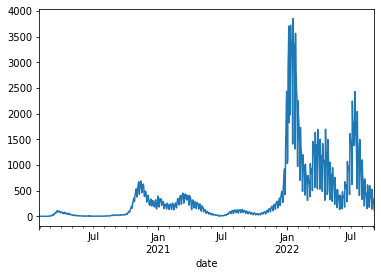

In [6]:
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

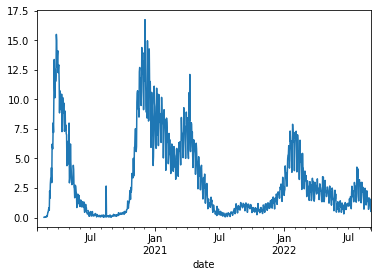

In [7]:
df_country['new_deaths_per_million'].plot()

In [8]:
# check missing data
df_country.isna().sum()

location                   0
new_cases_per_million      1
new_deaths_per_million    22
dtype: int64

In [9]:
df_country = ts_filling(df_country)

In [10]:
# check missing data
df_country.isna().sum()

location                  0
new_cases_per_million     0
new_deaths_per_million    0
dtype: int64

<AxesSubplot:xlabel='date'>

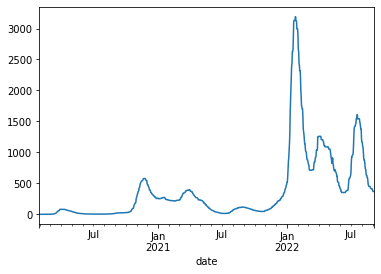

In [11]:
# smooth time series
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

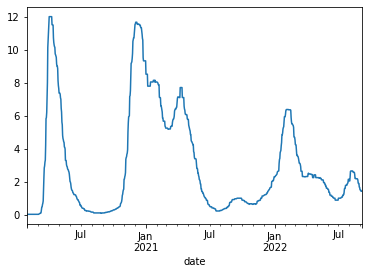

In [12]:
df_country['new_deaths_per_million'].plot()

# Feature Engineering

In [13]:
df_country

,location,new_cases_per_million,new_deaths_per_million
date,,,
2020-01-31,Italy,0.000,0.017
2020-02-01,Italy,0.000,0.017
2020-02-02,Italy,0.000,0.017
2020-02-03,Italy,0.000,0.017
2020-02-04,Italy,0.000,0.017
...,...,...,...
2022-09-01,Italy,371.284,1.485
2022-09-02,Italy,368.229,1.485
2022-09-03,Italy,368.026,1.418


In [14]:
# calculate new deaths percent change 
df_country = add_new_deaths_pct_change(df_country)
# calculate case fatality rate
df_country = add_case_fatality_rate(df_country)

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_25168\2957906252.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['case_fatality_rate'][df['new_cases_per_million']==0] = 0
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_25168\2957906252.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['case_fatality_rate'][df['new_deaths_per_million']==0] = 0
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_25168\2957906252.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [15]:
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,
2020-02-20,Italy,0.000,0.017,0.000000,0.000000
2020-02-21,Italy,0.000,0.017,0.000000,0.000000
2020-02-22,Italy,0.000,0.017,0.000000,0.000000
2020-02-23,Italy,0.000,0.017,0.000000,0.000000
2020-02-24,Italy,0.000,0.017,0.000000,0.000000
...,...,...,...,...,...
2022-09-01,Italy,371.284,1.485,-0.323154,0.002775
2022-09-02,Italy,368.229,1.485,-0.318182,0.002800
2022-09-03,Italy,368.026,1.418,-0.348944,0.002800


<AxesSubplot:xlabel='date'>

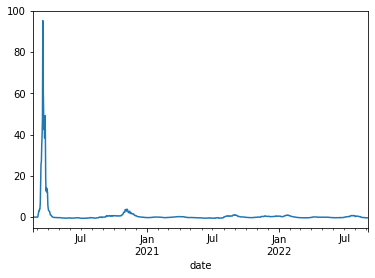

In [16]:
df_country['new_deaths_per_million_pct_change'].plot()

<AxesSubplot:xlabel='date'>

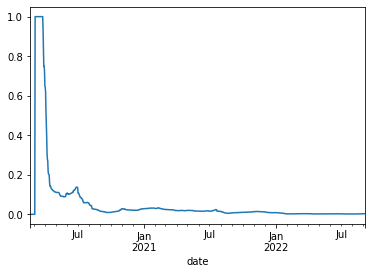

In [17]:
df_country['case_fatality_rate'].plot()

# Add Target

In [18]:
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,
2020-02-20,Italy,0.000,0.017,0.000000,0.000000
2020-02-21,Italy,0.000,0.017,0.000000,0.000000
2020-02-22,Italy,0.000,0.017,0.000000,0.000000
2020-02-23,Italy,0.000,0.017,0.000000,0.000000
2020-02-24,Italy,0.000,0.017,0.000000,0.000000
...,...,...,...,...,...
2022-09-01,Italy,371.284,1.485,-0.323154,0.002775
2022-09-02,Italy,368.229,1.485,-0.318182,0.002800
2022-09-03,Italy,368.026,1.418,-0.348944,0.002800


In [19]:
# add target i.e. deaths in 28 days
df_country['new_deaths_per_million' + '_future'] = df_country['new_deaths_per_million'].shift(-14)#
df_country.dropna(axis=0, inplace=True)
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate,new_deaths_per_million_future
date,,,,,,
2020-02-20,Italy,0.000,0.017,0.000000,0.000000,0.034
2020-02-21,Italy,0.000,0.017,0.000000,0.000000,0.051
2020-02-22,Italy,0.000,0.017,0.000000,0.000000,0.068
2020-02-23,Italy,0.000,0.017,0.000000,0.000000,0.068
2020-02-24,Italy,0.000,0.017,0.000000,0.000000,0.084
...,...,...,...,...,...,...
2022-08-18,Italy,535.092,2.194,-0.161315,0.002018,1.485
2022-08-19,Italy,479.791,2.178,-0.178113,0.002102,1.485
2022-08-20,Italy,460.683,2.178,-0.178113,0.002121,1.418


In [20]:
# plot multiple time series with moving avgs in a loop
import plotly.express as px
fig = px.line(df_country, x=df_country.index, y=["new_deaths_per_million"], title = country, template = 'plotly_dark')
fig.show()

# Simple Analytical Model # 1

In [21]:
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate,new_deaths_per_million_future
date,,,,,,
2020-02-20,Italy,0.000,0.017,0.000000,0.000000,0.034
2020-02-21,Italy,0.000,0.017,0.000000,0.000000,0.051
2020-02-22,Italy,0.000,0.017,0.000000,0.000000,0.068
2020-02-23,Italy,0.000,0.017,0.000000,0.000000,0.068
2020-02-24,Italy,0.000,0.017,0.000000,0.000000,0.084
...,...,...,...,...,...,...
2022-08-18,Italy,535.092,2.194,-0.161315,0.002018,1.485
2022-08-19,Italy,479.791,2.178,-0.178113,0.002102,1.485
2022-08-20,Italy,460.683,2.178,-0.178113,0.002121,1.418


In [22]:
# the simple model calculates the deaths simply as the new cases multiplied by the case fatality rate
df_country['simple_prediction_01'] = df_country['new_cases_per_million'] * df_country['case_fatality_rate']
# apply some smoothing
df_country['simple_prediction_01'] = df_country['simple_prediction_01'].rolling(14).median()#.fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
# drop nas
df_country.dropna(axis=0, inplace=True)

In [23]:
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate,new_deaths_per_million_future,simple_prediction_01
date,,,,,,,
2020-03-04,Italy,1.249,0.017,0.000000,0.000000,1.637,0.000000
2020-03-05,Italy,1.570,0.034,1.000000,1.000000,2.245,0.000000
2020-03-06,Italy,1.570,0.051,2.000000,1.000000,2.836,0.000000
2020-03-07,Italy,2.211,0.068,3.000000,1.000000,2.954,0.000000
2020-03-08,Italy,3.410,0.068,3.000000,1.000000,3.190,0.000000
...,...,...,...,...,...,...,...
2022-08-18,Italy,535.092,2.194,-0.161315,0.002018,1.485,1.266675
2022-08-19,Italy,479.791,2.178,-0.178113,0.002102,1.485,1.214342
2022-08-20,Italy,460.683,2.178,-0.178113,0.002121,1.418,1.175723


<AxesSubplot:xlabel='date'>

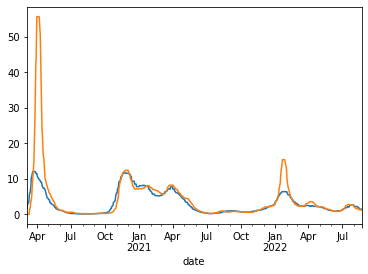

In [24]:
df_country['new_deaths_per_million_future'].plot()
df_country['simple_prediction_01'].plot()

# Simple Analytical Model # 2

In [25]:
df_country

,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate,new_deaths_per_million_future,simple_prediction_01
date,,,,,,,
2020-03-04,Italy,1.249,0.017,0.000000,0.000000,1.637,0.000000
2020-03-05,Italy,1.570,0.034,1.000000,1.000000,2.245,0.000000
2020-03-06,Italy,1.570,0.051,2.000000,1.000000,2.836,0.000000
2020-03-07,Italy,2.211,0.068,3.000000,1.000000,2.954,0.000000
2020-03-08,Italy,3.410,0.068,3.000000,1.000000,3.190,0.000000
...,...,...,...,...,...,...,...
2022-08-18,Italy,535.092,2.194,-0.161315,0.002018,1.485,1.266675
2022-08-19,Italy,479.791,2.178,-0.178113,0.002102,1.485,1.214342
2022-08-20,Italy,460.683,2.178,-0.178113,0.002121,1.418,1.175723


In [26]:
# this model linearely extrapolates the number deaths i.e. #deaths now x (1+pct_change)
df_country['simple_prediction_02'] = df_country['new_deaths_per_million'] * (1+df_country['new_deaths_per_million_pct_change'])
# apply some smoothing
df_country['simple_prediction_02'] = df_country['simple_prediction_02'].rolling(14).median()#.fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
# drop nas
df_country.dropna(axis=0, inplace=True)

<AxesSubplot:xlabel='date'>

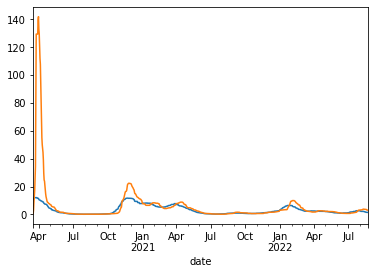

In [27]:
df_country['new_deaths_per_million_future'].plot()
df_country['simple_prediction_02'].plot()

# Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
df_train, df_test = train_test_split(df_country, test_size=0.4, shuffle=False, random_state=123)

<AxesSubplot:xlabel='date'>

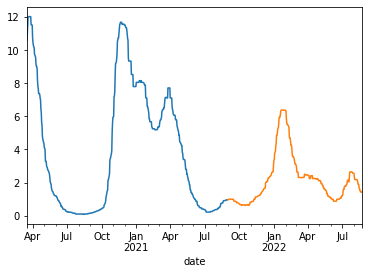

In [30]:
df_train['new_deaths_per_million_future'].plot()
df_test['new_deaths_per_million_future'].plot()

In [31]:
from pycaret.regression import *

In [32]:
df_train.columns

Index(['location', 'new_cases_per_million', 'new_deaths_per_million',
       'new_deaths_per_million_pct_change', 'case_fatality_rate',
       'new_deaths_per_million_future', 'simple_prediction_01',
       'simple_prediction_02'],
      dtype='object')

In [33]:
# initialize setup from pycaret.regression
s = setup(df_train, 
        target = 'new_deaths_per_million_future',
        ignore_features = ['location'],
        train_size = .99,
        data_split_shuffle = False, 
        fold_strategy = 'timeseries', fold=2,
        imputation_type = 'simple',
        numeric_imputation = 'median',
        remove_multicollinearity = True,
        multicollinearity_threshold = 0.6,
        feature_interaction=False,
        polynomial_features=False,
        remove_outliers = False,
        transform_target=False,
        transformation = False,
        normalize = False,
        feature_selection = True,
        feature_selection_threshold = 0.6,
        silent = True, 
        verbose = True, 
        session_id = 123)

,Description,Value
0,session_id,123
1,Target,new_deaths_per_million_future
2,Original Data,"(533, 8)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(527, 1)"


In [34]:
# compare all models and select best one based on MAE
best_model = compare_models(include=['xgboost', 'gbr', 'lr', 'dummy', 'lightgbm'], 
                            sort='RMSE', 
                            verbose=True,
                            n_select = 1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.2557,3.2477,1.7034,0.7195,0.3710,0.7338,1.1050
lightgbm,Light Gradient Boosting Machine,1.5543,4.7507,2.1728,0.5126,0.4361,0.7473,1.1350
gbr,Gradient Boosting Regressor,1.8572,6.8096,2.6074,0.2829,0.4931,0.7933,1.1700
xgboost,Extreme Gradient Boosting,2.1570,9.4742,3.0777,-0.0149,0.5432,0.8577,2.3150
dummy,Dummy Regressor,3.6111,17.1808,4.0506,-0.6068,0.9127,3.5749,1.1000


In [35]:
best_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5422,5.5410,2.3539,0.5962,0.4217,0.3205
1,0.7307,0.8089,0.8994,0.8840,0.2163,0.4275
Mean,1.1365,3.1750,1.6267,0.7401,0.3190,0.3740
Std,0.4058,2.3661,0.7273,0.1439,0.1027,0.0535


In [36]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [37]:
best_model = finalize_model(best_model)

In [38]:
df_train = predict_model(best_model, data=df_train)
df_test = predict_model(best_model, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.1462,3.8270,1.9563,0.7353,0.3367,0.4130


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.5516,0.6622,0.8138,0.6981,0.2044,0.2333


<AxesSubplot:xlabel='date'>

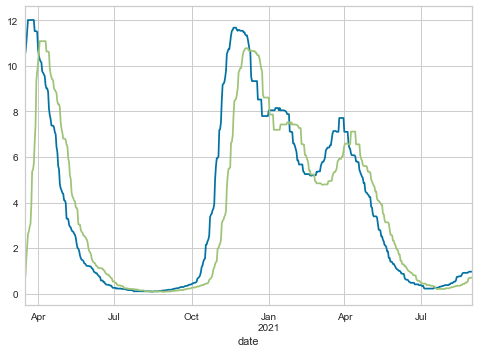

In [39]:
df_train['new_deaths_per_million_future'].plot()
df_train['Label'].plot()

<AxesSubplot:xlabel='date'>

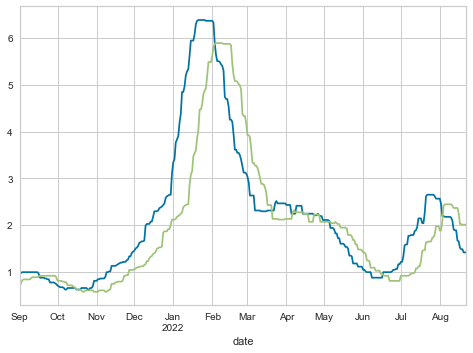

In [40]:
df_test['new_deaths_per_million_future'].plot()
df_test['Label'].plot()

In [41]:
df_country = predict_model(best_model, data=df_country)
df_country.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.9081,2.5596,1.5999,0.7509,0.2910,0.3410


,location,new_cases_per_million,new_deaths_per_million,new_deaths_per_million_pct_change,case_fatality_rate,new_deaths_per_million_future,simple_prediction_01,simple_prediction_02,Label
date,,,,,,,,,
2020-03-17,Italy,16.492,0.827,47.647059,1.0,10.584,4.9120,0.743559,0.762990
2020-03-18,Italy,21.050,1.637,95.294118,1.0,10.989,6.8195,3.254147,1.510296
2020-03-19,Italy,25.186,2.245,65.029412,1.0,11.529,8.7100,8.833882,2.071237
2020-03-20,Italy,30.334,2.836,54.607843,1.0,12.019,9.7315,12.696029,2.616493
2020-03-21,Italy,39.044,2.954,42.441176,1.0,12.019,11.4450,17.452735,2.725360


In [42]:
fig = px.line(df_country, x=df_country.index, y=["new_deaths_per_million_future", 
                                                 'simple_prediction_01',
                                                 'simple_prediction_02',
                                                 'Label'], title = country, template = 'plotly_dark')
fig.show()